In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
# import jax.numpy as jnp
# from jax import jacfwd, random

from scipy.stats import wishart
from scipy.special import psi, loggamma
import matplotlib.pyplot as plt
from scipy.linalg import cholesky

import numpy as np
from numba import njit, prange

In [16]:
import numpy as np
from numba import njit, prange

@njit
def sum_of_pairs(variables):
    n = len(variables)
    pairwise_sum = 0.0
    for i in range(n):
        for j in range(i+1, n):
            pairwise_sum += variables[i] * variables[j]
    return pairwise_sum

@njit
def sum_of_triples(variables):
    n = len(variables)
    triplewise_sum = 0.0
    for i in range(n):
        for j in range(i+1, n):
            for k in range(j+1, n):
                triplewise_sum += variables[i] * variables[j] * variables[k]
    return triplewise_sum

@njit
def check_inequalities(variables, degree_last_inequality):
    sum_vars = np.sum(variables)
    
    # Sum of pairwise products
    pairwise_sum = sum_of_pairs(variables)
    
    # Depending on the degree of the last inequality, compute the sum of higher-order products
    if degree_last_inequality == 1:
        return 1 <= sum_vars
    if degree_last_inequality == 2:
        return 1 <= sum_vars <= pairwise_sum
    elif degree_last_inequality == 3:
        triplewise_sum = sum_of_triples(variables)
        return 1 <= sum_vars <= pairwise_sum <= triplewise_sum
    else:
        raise ValueError("This program supports up to degree 3 inequalities.")

def generate_combinations(n, steps=30):
    values = np.linspace(-1 + 1.0/steps, 1.0 - 1.0/steps, steps)
    return np.array(np.meshgrid(*[values]*n)).T.reshape(-1, n)

# @njit(parallel=True)
def find_solutions_parallel(combinations, degree_last_inequality):
    solutions = []
    for i in prange(combinations.shape[0]):
        variables = combinations[i]
        if check_inequalities(variables, degree_last_inequality):
            solutions.append(variables)
    return solutions

def find_solutions(n, degree_last_inequality, steps=30):
    combinations = generate_combinations(n, steps)
    solutions = find_solutions_parallel(combinations, degree_last_inequality)
    return solutions

# Input for the number of variables and the degree of the last inequality
n = 4
degree_last_inequality = 2

# Find and display the solutions
solutions = find_solutions(n, degree_last_inequality, steps=10)
print(f"Found {len(solutions)} solutions:")
for sol in solutions:
    print(sol)


Found 66 solutions:
[0.9 0.9 0.7 0.3]
[0.7 0.9 0.9 0.3]
[0.9 0.7 0.9 0.3]
[0.9 0.9 0.9 0.3]
[0.9 0.9 0.5 0.5]
[0.7 0.9 0.7 0.5]
[0.9 0.7 0.7 0.5]
[0.9 0.9 0.7 0.5]
[0.5 0.9 0.9 0.5]
[0.7 0.7 0.9 0.5]
[0.7 0.9 0.9 0.5]
[0.9 0.5 0.9 0.5]
[0.9 0.7 0.9 0.5]
[0.9 0.9 0.9 0.5]
[0.9 0.9 0.3 0.7]
[0.7 0.9 0.5 0.7]
[0.9 0.7 0.5 0.7]
[0.9 0.9 0.5 0.7]
[0.5 0.9 0.7 0.7]
[0.7 0.7 0.7 0.7]
[0.7 0.9 0.7 0.7]
[0.9 0.5 0.7 0.7]
[0.9 0.7 0.7 0.7]
[0.9 0.9 0.7 0.7]
[0.3 0.9 0.9 0.7]
[0.5 0.7 0.9 0.7]
[0.5 0.9 0.9 0.7]
[0.7 0.5 0.9 0.7]
[0.7 0.7 0.9 0.7]
[0.7 0.9 0.9 0.7]
[0.9 0.3 0.9 0.7]
[0.9 0.5 0.9 0.7]
[0.9 0.7 0.9 0.7]
[0.9 0.9 0.9 0.7]
[0.7 0.9 0.3 0.9]
[0.9 0.7 0.3 0.9]
[0.9 0.9 0.3 0.9]
[0.5 0.9 0.5 0.9]
[0.7 0.7 0.5 0.9]
[0.7 0.9 0.5 0.9]
[0.9 0.5 0.5 0.9]
[0.9 0.7 0.5 0.9]
[0.9 0.9 0.5 0.9]
[0.3 0.9 0.7 0.9]
[0.5 0.7 0.7 0.9]
[0.5 0.9 0.7 0.9]
[0.7 0.5 0.7 0.9]
[0.7 0.7 0.7 0.9]
[0.7 0.9 0.7 0.9]
[0.9 0.3 0.7 0.9]
[0.9 0.5 0.7 0.9]
[0.9 0.7 0.7 0.9]
[0.9 0.9 0.7 0.9]
[0.3 0.7 0.9 0.9]
[0.3 0.9

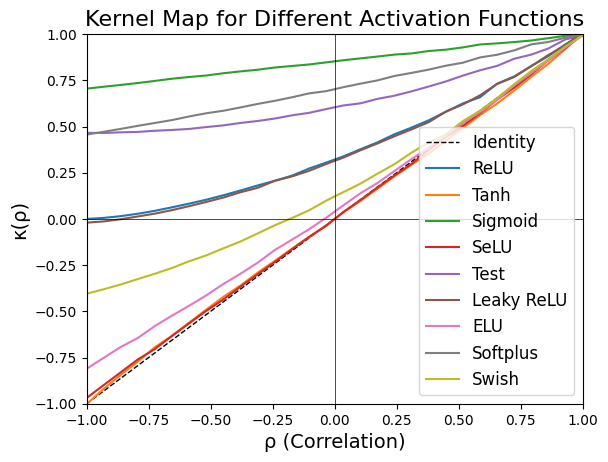

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Define the activation functions
activations = {
    'ReLU': torch.nn.ReLU(),
    'Tanh': torch.nn.Tanh(),
    'Sigmoid': torch.nn.Sigmoid(),
    'SeLU': torch.nn.SELU(),
    'Test': lambda x: 0.5 + 0.5 * x + 0.25 * x**2,
    'Leaky ReLU': torch.nn.LeakyReLU(negative_slope=0.01),
    'ELU': torch.nn.ELU(),
    'Softplus': torch.nn.Softplus(),
    'Swish': lambda x: x * torch.sigmoid(x)
}


def kernel_map(activation, rho_values, normalize=False, num_samples=100000):
    kappa_values = []
    
    # Compute kappa(1) for normalization if required
    if normalize:
        X = torch.randn(num_samples)
        phi_X = activation(X)
        kappa_1 = (phi_X * phi_X).mean().item() ** 0.5
    else:
        kappa_1 = 1.0
    
    for rho in rho_values:
        X = torch.randn(num_samples)
        Y = rho * X + (1 - rho ** 2)**0.5 * torch.randn(num_samples)
        
        phi_X = activation(X) / kappa_1  # Normalize if required
        phi_Y = activation(Y) / kappa_1  # Normalize if required
        kappa = (phi_X * phi_Y).mean().item()
        kappa_values.append(kappa)
    
    return kappa_values

# Define the range of rho values
rho_values = np.linspace(-1, 1, 30)

# Plot the kernel map for each activation function
plt.figure()

# Add the identity line
plt.plot(rho_values, rho_values, 'k--', label='Identity', linewidth=1)

# Plot each activation's kernel map
for name, activation in activations.items():
    kappa_values = kernel_map(activation, rho_values,normalize=True)
    plt.plot(rho_values, kappa_values, label=name)

# Enhance the plot's aesthetics
plt.title('Kernel Map for Different Activation Functions', fontsize=16)
plt.xlabel('ρ (Correlation)', fontsize=14)
plt.ylabel('κ(ρ)', fontsize=14)
plt.legend(fontsize=12)
# plt.grid(False)  # Remove the grid
plt.axhline(0, color='black', linewidth=0.5)  # Add a horizontal line at y=0
plt.axvline(0, color='black', linewidth=0.5)  # Add a vertical line at x=0
plt.xlim([-1, 1])
plt.ylim([-1, 1])

# Display the plot
plt.show()


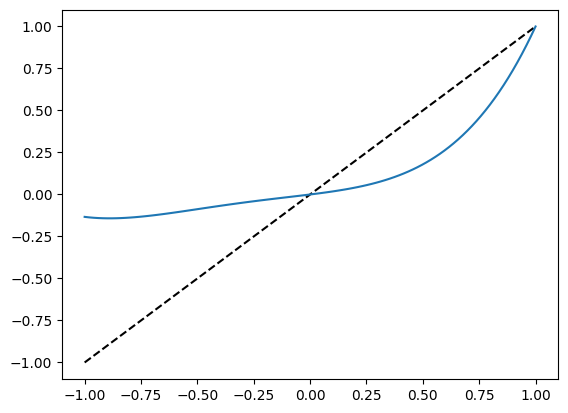

In [29]:
a, b = 0.5, 0.1
coefs = [0, 0, 6*a*b, 2*(a+b), 1]
coefs[1] += 0.5
coefs = coefs / np.sum(coefs)
f = lambda x: sum([c * x**i for i, c in enumerate(coefs)])


x = np.linspace(-1, 1, 100)
y = f(x)
# identity
plt.plot(x, x, 'k--')
plt.plot(x, y)


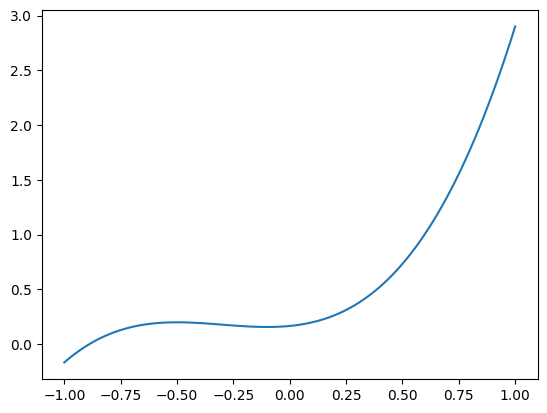

In [30]:
coefs
f_prime = lambda x: sum([i * c * x**(i-1) for i, c in enumerate(coefs)])
x = np.linspace(-1, 1, 100)
y = f_prime(x)
plt.plot(x, y)



In [31]:
coefs

array([0.        , 0.16666667, 0.1       , 0.4       , 0.33333333])